Create new T+S initial conditions for tidal runs with new bathymetry. This should work for both bathy6 and bathy9.

Tidal runs are April 21 to May 30 2003

In [2]:
from __future__ import division, print_function
from salishsea_tools import (nc_tools,viz_tools,tidetools,bathy_tools)
from salishsea_tools.nowcast import figures
import scipy.io as sio
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
%matplotlib inline

# Create TS for bathymetry6

In [3]:
#old bathymetry inforamtion
old_path = '/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
old_bathy = nc.Dataset(old_path, 'r')
old_depth = old_bathy.variables['Bathymetry']

In [4]:
#old initial file
initial_path = '/ocean/dlatorne/MEOPAR/SalishSea/results/spin-up/11apr20apr/SalishSea_01529280_restart.nc'
T_S = nc.Dataset(initial_path, 'r')

In [5]:
#nc_tools.show_variables(T_S)
old_T = T_S.variables['tb'][0] # omit the first dimension
old_S = T_S.variables['sb'][0]
depths = T_S.variables['nav_lev']
lon = T_S.variables['nav_lon']
lat = T_S.variables['nav_lat']
print (old_T[:, 427, 292])
print(depths[0:40])

[ 11.1456967   10.0427125    9.52772441   9.36103375   9.22431898
   9.1190091    9.05160312   8.99361242   8.93174205   8.8828761
   8.84217754   8.8166084    8.79470825   8.75026094   8.72955683
   8.71239039   8.69184383   8.67646045   8.66204948   8.65590447
   8.61186428   8.54911484   8.52412015   0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.        ]
[   0.5000003     1.5000031     2.50001144    3.50003052    4.50007057
    5.50015068    6.50031042    7.50062323    8.50123596    9.50243282
   10.50476551   11.50931168   12.51816654   13.53541183   14.56898212
   15.63428783   16.76117325   18.00713539   19.48178482   21.38997841
   24.10025597   28.22991562   34.68575668   44.51772308   58.48433304
   76.58558655   98.06295776  121.86651611  147.08946228  173.11448669
  199.57304382  226.26029968  253.06663513  279.93453979  306.8

(898, 398)


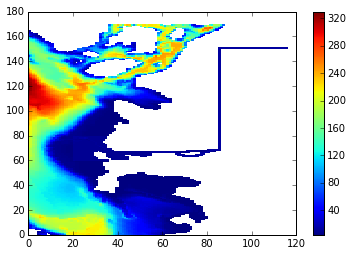

In [6]:
#read in new bathymetry
new_path = '/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea6.nc'
Fraser = nc.Dataset(new_path, 'r')
bathy = Fraser.variables['Bathymetry'][:]
print(bathy.shape)
plt.pcolormesh(bathy[350: 520, 280 : 398])
plt.colorbar()

In [7]:
floor = np.empty_like(depths)
ceil = np.empty_like(depths)
ceil[0] = 0.
floor[0] = 2*depths[0]
for k in range(1,40):
    ceil[k] = floor[k-1]
    floor[k] = 2*depths[k] -floor[k-1]

In [11]:
S = np.empty_like(old_S)
T = np.empty_like(old_T)
#for every cell with top of cell depth < bathymetry, use old TS, if old TS=0, find closest point and use that.
for k in range(40):
    for j in range(398):
        for i in range(898):
            if ceil[k] < bathy[i,j]:
                if old_S[k,i,j] > 0 and old_T[k,i,j]>0:
                    S[k,i,j] = old_S[k, i, j]
                    T[k,i,j] = old_T[k, i, j]
                else:
                    # closest neighbour thing
                    masked_array = np.ma.array(old_T[k], mask = old_T[k] == 0)
                    X, Y = tidetools.find_closest_model_point(lon[i,j], lat[i,j], lon, lat, masked_array)
                    S[k, i, j] = old_S[k, X, Y]
                    T[k, i, j] = old_T[k, X, Y]

In [14]:
# build nc file
filename = '/data/nsoontie/MEOPAR/NEMO-forcing/initial_strat/TS_tides_bathy6.nc'
new_TS = nc.Dataset(filename, 'w')
nc_tools.init_dataset_attrs(
    new_TS, 
    title='Salinity Temperature Initial Conditions based on spinup restart file 11apr20apr for bathymetry6', 
    notebook_name='Create New TS file bathymetry6&9', 
    nc_filepath=filename,
    comment='Salinity Temperature Initial Conditions based on spinup restart file 11apr20apr for bathymetry6')
new_TS.createDimension('y', 898)
new_TS.createDimension('x', 398)
new_TS.createDimension('deptht',size = len(depths))
new_TS.createDimension('time_counter', None)
#nc_tools.show_dimensions(new_TS)
# show variables
nav_lat = new_TS.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat = lat
nav_lon = new_TS.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon = lon
deptht = new_TS.createVariable('deptht', 'float32', ('deptht'))
deptht.long_name = 'Depth'
deptht.units = 'm'
deptht.positive = 'down'
deptht.valid_range = np.array((4., 428.))##minimum depth 4m
deptht = depths
time_counter = new_TS.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.long_name = 'Time axis'
vosaline = new_TS.createVariable('vosaline', 'float32', 
                               ('time_counter','deptht','y','x'))
vosaline.units = 'none'
vosaline.long_name = 'Practical Salinity'  
vosaline.coordinates = 'nav_lon nav_lat deptht time_counter'
vosaline.grid = 'SalishSea6, north extended Fraser'
vosaline[0] = S
votemper = new_TS.createVariable('votemper', 'float32', 
                               ('time_counter','deptht','y','x'))
votemper.units = 'degC'
votemper.long_name = 'Temperature' 
votemper.coordinates = 'nav_lon nav_lat deptht time_counter'
votemper[0] = T
new_TS.history = """[2015-06-14] Created"""

file format: NETCDF4
Conventions: CF-1.6
title: Salinity Temperature Initial Conditions based on spinup restart file 11apr20apr for bathymetry6
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/I_ForcingFiles/Initial/Create New TS file bathymetry6&9.ipynb
references: REQUIRED
history: [2015-10-15 17:04:52] Created netCDF4 zlib=True dataset.
comment: Salinity Temperature Initial Conditions based on spinup restart file 11apr20apr for bathymetry6


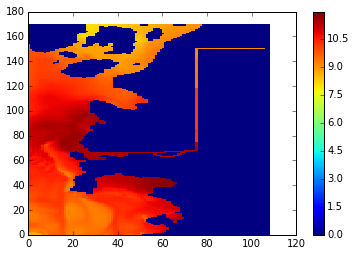

In [15]:
## temperature before
plt.pcolormesh(votemper[0,0, 350: 520, 290 : 398])
plt.colorbar()

In [16]:
## modify temperature for some grid cells
k = 0 
i = 413
j = 351
votemper[0,  : , i, j : j + 5] = 14. ## for(413, 351:355) from 0 to 4m
votemper[0,  : , i + 4, j + 4: j +13] = 14. ## for (417, 355:363).. ..
votemper[0,  : , i + 1, j + 4: j + 7] = 14. ## for (414, 355:357).. ..
votemper[0,  : , i + 2, j + 6: j + 8] = 14. ## for (415, 357:358).. ..
votemper[0,  : , i + 3, j + 7: j + 10] = 14. ## for (416, 358:360).. ..
votemper[0,  : , i + 5, j + 9: j + 15] = 14. ## for (418, 360:365).. ..
## plus north ones(all depth):
votemper[0, k : , i + 5 : i + 88,  j + 14] = 14. ## for (418-500, 365).. ..
votemper[0, k : ,  i + 87,  j+ 14 : j + 45] = 14. ## for (500, 365-395)

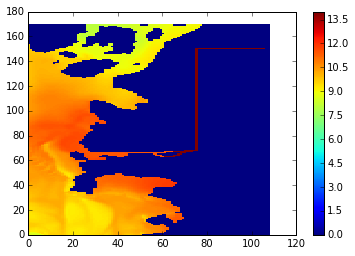

In [17]:
## temperature after
plt.pcolormesh(votemper[0,0, 350: 520, 290 : 398])
plt.colorbar()

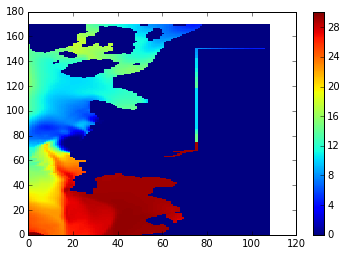

In [18]:
## salinity before
plt.pcolormesh(vosaline[0,0, 350: 520, 290 : 398])
plt.colorbar()

In [19]:
## set salinity after New Westminster as 1,before as 0,river source cell as 0
k = 0 
i = 418
j = 365
vosaline[0,  :, i-2, j-30: j-13] = 0.#16,335:351)(416 ,358:360)
vosaline[0,  :, i -2, j -7: j -4] = 0.
vosaline[0,  :, i -1,j -14:j -1] = 0.#(417, 351:363)..  ..
vosaline[0,  :, i - 4, j - 18: j - 15] = 0.## for (414, 347:349)( 414, 355:357).. ..
vosaline[0,  :, i - 4, j - 10: j - 7] = 0.
vosaline[0,  :, i - 5,j - 16:j- 9]=0.## for (413, 349:355)
vosaline[0,  :, i - 3, j  - 19:j-17] =0.#(415, 346, 347, 357, 358).. ..
vosaline[0,  :, i - 3, j  - 8: j - 6] = 0.
vosaline[0,  :, i , j -5 : j +1] = 0.#for(418,360:365) .. ..New Westminster
## plus north ones(all depth):
vosaline[0,  : , i: i+ 83 ,  j]  = 0. ## for (418-500, 365).. ..
vosaline[0,  : ,  i + 82,  j : j + 30] = 0. ## for (500, 365-394)

In [20]:
## make salinity(500, 395)==0(source) for all depth
vosaline[0,  : ,  500,  395] = 0.

In [21]:
## make original salinity of freshwater source point as 4
vosaline[0, 0:4 , 416, 334] = 1.

In [22]:
## modify damp salinity values but not for the widen part
k = 0; i = 425; j = 302; d = 1.
vosaline[0, k: k +4, i, j+1] = d
vosaline[0, k: k +4, i-1, j:j+3] = d
vosaline[0, k: k +4, i-2, j+1:j+5] = d
vosaline[0, k: k +4, i-3, j+3:j+7] = d
vosaline[0, k: k +4, i-4, j+5:j+9] = d
vosaline[0, k: k +4, i-5, j+7:j+11] = d
vosaline[0, k: k +4, i-6, j+9:j+13] = d
vosaline[0, k: k +4, i-7, j+11:j+14] = d
vosaline[0, k: k +4, i-8, j+12:j+16] = d

In [23]:
## modify salinity values of straight channel connect damp and further extended channel
k = 0; i = 416; j = 317; d= 1.
vosaline[0, k : k +4, i, j-1:j+18] = d

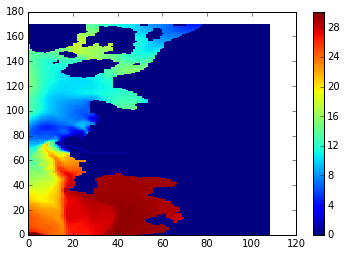

In [24]:
## salinity after
plt.pcolormesh(vosaline[0,0, 350: 520, 290 : 398])
plt.colorbar()

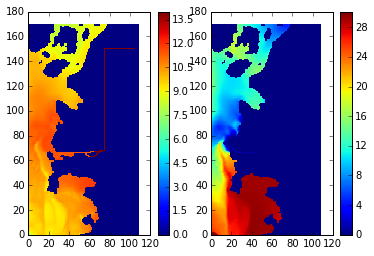

In [25]:
plt.subplot(1, 2, 1)
plt.pcolormesh(votemper[0,0, 350: 520, 290 : 398])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolormesh(vosaline[0,0, 350: 520, 290 : 398])
plt.colorbar()

In [26]:
new_TS.close()

# Create TS file for bathymetry 6 for sep25-oct7 spin up, then hindcast

In [3]:
#old initial file
initial_path = '/data/dlatorne/MEOPAR/SalishSea/nowcast/early-days/24-26sep14/SalishSea_00129600_restart.nc'
T_S = nc.Dataset(initial_path, 'r')

In [4]:
#nc_tools.show_variables(T_S)
old_T = T_S.variables['tb'][0] # omit the first dimension
old_S = T_S.variables['sb'][0]
depths = T_S.variables['nav_lev']
lon = T_S.variables['nav_lon']
lat = T_S.variables['nav_lat']
print (old_T[:, 427, 292])
print(depths[0:40])

[ 16.07758754  16.06995039  15.95650878  15.80249028  15.40679218
  14.96464942  14.64882925  14.41677323  14.10704308  13.88312656
  13.75059047  13.63027657  13.53098886  13.36371394  13.24643531
  13.12736562  13.0202796   12.94171459  12.8280736   12.70510011
  12.52621711  12.28949568  12.09501551   0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.        ]
[   0.5000003     1.5000031     2.50001144    3.50003052    4.50007057
    5.50015068    6.50031042    7.50062323    8.50123596    9.50243282
   10.50476551   11.50931168   12.51816654   13.53541183   14.56898212
   15.63428783   16.76117325   18.00713539   19.48178482   21.38997841
   24.10025597   28.22991562   34.68575668   44.51772308   58.48433304
   76.58558655   98.06295776  121.86651611  147.08946228  173.11448669
  199.57304382  226.26029968  253.06663513  279.93453979  306.

(898, 398)


<matplotlib.colorbar.Colorbar instance at 0x7f744fb09e60>

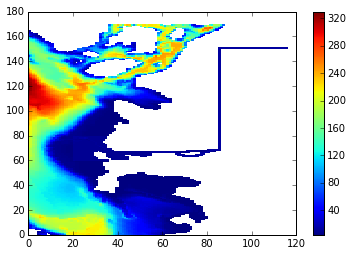

In [5]:
#read in new bathymetry
new_path = '/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc'
Fraser = nc.Dataset(new_path, 'r')
bathy = Fraser.variables['Bathymetry'][:]
print(bathy.shape)
plt.pcolormesh(bathy[350: 520, 280 : 398])
plt.colorbar()

In [6]:
floor = np.empty_like(depths)
ceil = np.empty_like(depths)
ceil[0] = 0.
floor[0] = 2*depths[0]
for k in range(1,40):
    ceil[k] = floor[k-1]
    floor[k] = 2*depths[k] -floor[k-1]

In [7]:
S = np.empty_like(old_S)
T = np.empty_like(old_T)
#for every cell with top of cell depth < bathymetry, use old TS, if old TS=0, find closest point and use that.
for k in range(40):
    for j in range(398):
        for i in range(898):
            if ceil[k] < bathy[i,j]:
                if old_S[k,i,j] <> 0:
                    S[k,i,j] = old_S[k, i, j]
                    T[k,i,j] = old_T[k, i, j]
                else:
                    # closest neighbour thing
                    masked_array = np.ma.array(old_S[k], mask = old_S[k] == 0)
                    X, Y = tidetools.find_closest_model_point(lon[i,j], lat[i,j], lon, lat, masked_array)
                    S[k, i, j] = old_S[k, X, Y]
                    T[k, i, j] = old_T[k, X, Y]

In [8]:
# build nc file
new_TS = nc.Dataset('TSnorlessSep.nc', 'w')
nc_tools.init_dataset_attrs(
    new_TS, 
    title='Salinity Temperature Initial Conditions based on Nowcast Sep 24, 2014 for north-extended but not \
    to Howe Sound, and widen at beginning Fraser river channel', 
    notebook_name='Smooth bathymetry & Create New TS file', 
    nc_filepath='/ocean/jieliu/research/meopar/nemo-forcing/initial_strat/TSnorless6.nc',
    comment='Salinity and Temperature conditions from nowcast Sep 24, 2014  onto north extended Fraser bathymetry')
new_TS.createDimension('y', 898)
new_TS.createDimension('x', 398)
new_TS.createDimension('deptht',size = len(depths))
new_TS.createDimension('time_counter', None)
nc_tools.show_dimensions(new_TS)
# show variables
nav_lat = new_TS.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat = lat
nav_lon = new_TS.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon = lon
deptht = new_TS.createVariable('deptht', 'float32', ('deptht'))
deptht.long_name = 'Depth'
deptht.units = 'm'
deptht.positive = 'down'
deptht.valid_range = np.array((4., 428.))##minimum depth 4m
deptht = depths
time_counter = new_TS.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.units = 'seconds since 2015-06-14 0:00:00'
time_counter.long_name = 'Time axis'
vosaline = new_TS.createVariable('vosaline', 'float32', 
                               ('time_counter','deptht','y','x'))
vosaline.units = 'none'
vosaline.long_name = 'Practical Salinity'  
vosaline.coordinates = 'nav_lon nav_lat deptht time_counter'
vosaline.grid = 'SalishSea6, north extended Fraser'
vosaline[0] = S
votemper = new_TS.createVariable('votemper', 'float32', 
                               ('time_counter','deptht','y','x'))
votemper.units = 'degC'
votemper.long_name = 'Temperature' 
votemper.coordinates = 'nav_lon nav_lat deptht time_counter'
votemper[0] = T
new_TS.history = """[2014-09-24] Created"""

file format: NETCDF4
Conventions: CF-1.6
title: Salinity Temperature Initial Conditions based on Nowcast Sep 24, 2014 for north-extended but not     to Howe Sound, and widen at beginning Fraser river channel
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: REQUIRED
references: REQUIRED
history: [2015-10-05 14:34:52] Created netCDF4 zlib=True dataset.
comment: Salinity and Temperature conditions from nowcast Sep 24, 2014  onto north extended Fraser bathymetry
<type 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 898

<type 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398

<type 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 40

<type 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 0



<matplotlib.colorbar.Colorbar instance at 0x7f743d702c20>

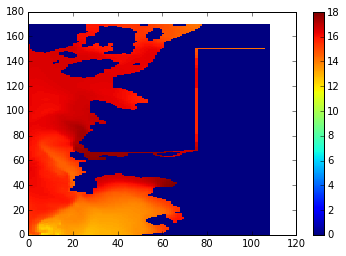

In [9]:
## temperature and I don't modify it further
plt.pcolormesh(votemper[0,0, 350: 520, 290 : 398])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f743d564830>

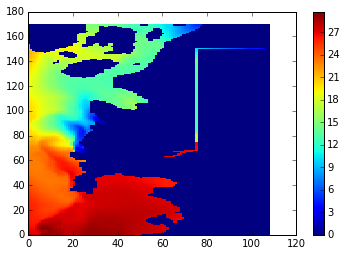

In [10]:
## salinity before and I need to modify it further
plt.pcolormesh(vosaline[0,0, 350: 520, 290 : 398])
plt.colorbar()

In [11]:
## set salinity after New Westminster as 1,before as 0,river source cell as 0
k = 0 
i = 418
j = 365
vosaline[0,  :, i-2, j-30: j-13] = 0.#16,335:351)(416 ,358:360)
vosaline[0,  :, i -2, j -7: j -4] = 0.
vosaline[0,  :, i -1,j -14:j -1] = 0.#(417, 351:363)..  ..
vosaline[0,  :, i - 4, j - 18: j - 15] = 0.## for (414, 347:349)( 414, 355:357).. ..
vosaline[0,  :, i - 4, j - 10: j - 7] = 0.
vosaline[0,  :, i - 5,j - 16:j- 9]=0.## for (413, 349:355)
vosaline[0,  :, i - 3, j  - 19:j-17] =0.#(415, 346, 347, 357, 358).. ..
vosaline[0,  :, i - 3, j  - 8: j - 6] = 0.
vosaline[0,  :, i , j -5 : j +1] = 0.#for(418,360:365) .. ..New Westminster
## plus north ones(all depth):
vosaline[0,  : , i: i+ 83 ,  j]  = 0. ## for (418-500, 365).. ..
vosaline[0,  : ,  i + 82,  j : j + 30] = 0. ## for (500, 365-394)

In [12]:
## make salinity(500, 395)==0(source) for all depth
vosaline[0,  : ,  500,  395] = 0.

In [13]:
## make original salinity of freshwater source point as 4
vosaline[0, : , 414:417, 334] = 1.

In [14]:
## modify damp salinity values but not for the widen part
k = 0; i = 425; j = 302; d = 1.
vosaline[0, k: k +4, i, j+1] = d
vosaline[0, k: k +4, i-1, j:j+3] = d
vosaline[0, k: k +4, i-2, j+1:j+5] = d
vosaline[0, k: k +4, i-3, j+3:j+7] = d
vosaline[0, k: k +4, i-4, j+5:j+9] = d
vosaline[0, k: k +4, i-5, j+7:j+11] = d
vosaline[0, k: k +4, i-6, j+9:j+13] = d
vosaline[0, k: k +4, i-7, j+11:j+14] = d
vosaline[0, k: k +4, i-8, j+12:j+16] = d

In [15]:
## modify salinity values of straight channel connect damp and further extended channel
k = 0; i = 416; j = 317; d= 1.
vosaline[0, k : k +4, i, j-1:j+18] = d

<matplotlib.colorbar.Colorbar instance at 0x7f743d459560>

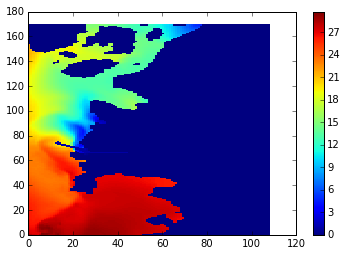

In [16]:
## salinity after
plt.pcolormesh(vosaline[0,0, 350: 520, 290 : 398])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f743d1649e0>

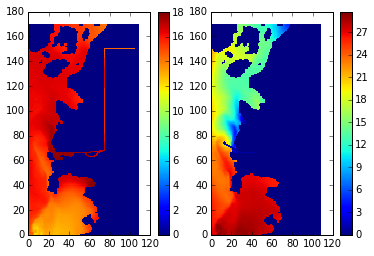

In [17]:
plt.subplot(1, 2, 1)
plt.pcolormesh(votemper[0,0, 350: 520, 290 : 398])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolormesh(vosaline[0,0, 350: 520, 290 : 398])
plt.colorbar()

In [18]:
new_TS.close()